Epoch 1: Loss=3.8565, Train Acc=0.1957, Val Acc=0.4114
Epoch 2: Loss=2.4609, Train Acc=0.5103, Val Acc=0.6597
Epoch 3: Loss=1.5222, Train Acc=0.7133, Val Acc=0.7113
Epoch 4: Loss=1.0702, Train Acc=0.7649, Val Acc=0.7573
Epoch 5: Loss=0.8219, Train Acc=0.8022, Val Acc=0.7727
Epoch 6: Loss=0.6469, Train Acc=0.8340, Val Acc=0.7964
Epoch 7: Loss=0.5188, Train Acc=0.8580, Val Acc=0.8061
Epoch 8: Loss=0.4230, Train Acc=0.8825, Val Acc=0.7978
Epoch 9: Loss=0.3520, Train Acc=0.8936, Val Acc=0.8047
Epoch 10: Loss=0.2876, Train Acc=0.9107, Val Acc=0.8243
Epoch 11: Loss=0.2624, Train Acc=0.9201, Val Acc=0.8103
Epoch 12: Loss=0.2283, Train Acc=0.9334, Val Acc=0.8201
Epoch 13: Loss=0.1952, Train Acc=0.9424, Val Acc=0.8201
Epoch 14: Loss=0.1597, Train Acc=0.9505, Val Acc=0.8131
Epoch 15: Loss=0.1278, Train Acc=0.9641, Val Acc=0.8271
Epoch 16: Loss=0.1087, Train Acc=0.9710, Val Acc=0.8396
Epoch 17: Loss=0.0900, Train Acc=0.9759, Val Acc=0.8326
Epoch 18: Loss=0.0737, Train Acc=0.9777, Val Acc=0.8326
E

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Li

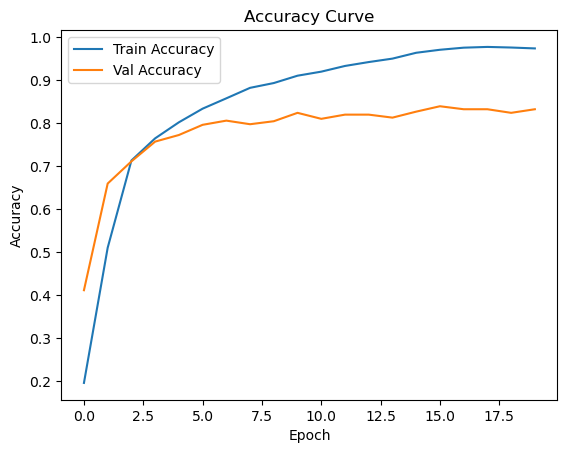

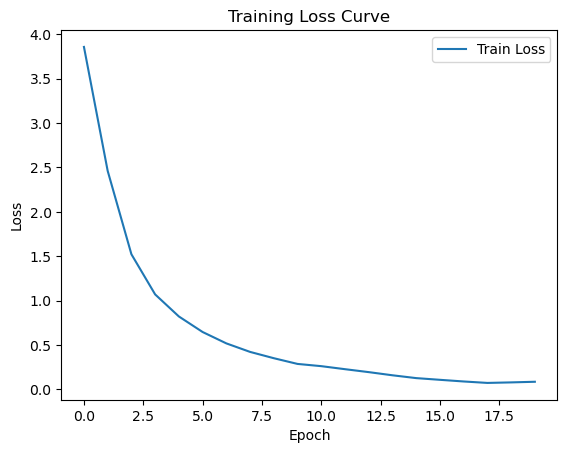

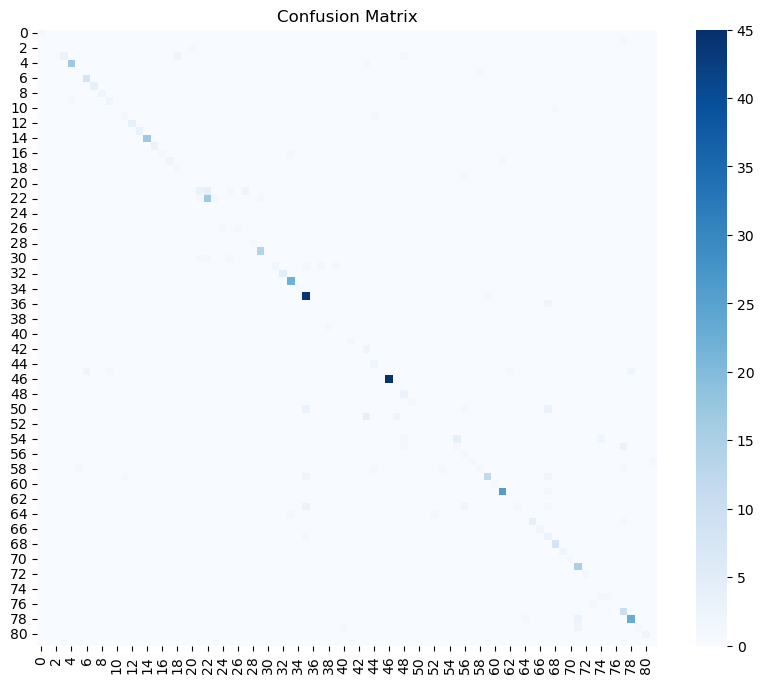

In [ ]:
# Egyptian Hieroglyphs CNN Training Script (with 50x75 preserved ratio)
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import os
from PIL import Image


dataset = load_dataset("imagefolder", data_dir="./Dataset/train")

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = self.transform(example["image"])
        label = example["label"]
        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((75, 50)),
    transforms.ToTensor()
])

split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = TransformedDataset(split["train"], transform)
val_dataset = TransformedDataset(split["test"], transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform, label_map):
        self.img_paths = []
        self.labels = []
        self.transform = transform
        self.label_map = label_map

        for file in os.listdir(img_dir):
            if not file.endswith(".png"):
                continue
            label_str = file.split("_")[-1].split(".")[0]
            if label_str.upper() == "UNKNOWN":
                continue
            if label_str not in label_map:
                continue  # 若 label_map 沒有這個 label，可以跳過或報錯
            self.img_paths.append(os.path.join(img_dir, file))
            self.labels.append(label_map[label_str])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("L")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label
    
# e.g., {"G1": 0, "M17": 1, ...}
label_map = {name: i for i, name in enumerate(dataset["train"].features["label"].names)}
test_dataset = TestDataset(img_dir="./Dataset/test", transform=transform, label_map=label_map)
test_loader = DataLoader(test_dataset, batch_size=64)


class EgyptianCNN(nn.Module):
    def __init__(self, num_classes):
        super(EgyptianCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)   # (1, 75, 50) -> (32, 73, 48)
        self.pool1 = nn.MaxPool2d(2)                   # -> (32, 36, 24)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # -> (64, 34, 22)
        self.pool2 = nn.MaxPool2d(2)                   # -> (64, 17, 11)
        self.fc1 = nn.Linear(64 * 17 * 11, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(dataset["train"].features["label"].names)
model = EgyptianCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(20):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print("\nFinal Test Accuracy:", test_accuracy)
print(classification_report(all_labels, all_preds))

os.makedirs("output", exist_ok=True)

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.savefig("output/accuracy_curve.png")

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.savefig("output/loss_curve.png")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("output/confusion_matrix.png")

report = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report).transpose().to_csv("output/classification_report.csv")



In [5]:
torch.save(model.state_dict(), "output/egyptian_cnn_weights.pth")
print("✅ Model weights saved to output/egyptian_cnn_weights.pth")


✅ Model weights saved to output/egyptian_cnn_weights.pth


In [6]:
import json

with open("output/label_map.json", "w") as f:
    json.dump(label_map, f)


In [3]:
# Egyptian Hieroglyphs CNN Training Script (with 50x75 preserved ratio)
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import os
from PIL import Image


dataset = load_dataset("imagefolder", data_dir="./Dataset/train")
num_classes = len(dataset["train"].features["label"].names)
print("Class count:", num_classes)
print("Class names:", dataset["train"].features["label"].names)


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Class count: 170
Class names: ['A55', 'Aa15', 'Aa26', 'Aa27', 'Aa28', 'D1', 'D10', 'D156', 'D19', 'D2', 'D21', 'D28', 'D34', 'D35', 'D36', 'D39', 'D4', 'D46', 'D52', 'D53', 'D54', 'D56', 'D58', 'D60', 'D62', 'E1', 'E17', 'E23', 'E34', 'E9', 'F12', 'F13', 'F16', 'F18', 'F21', 'F22', 'F23', 'F26', 'F29', 'F30', 'F31', 'F32', 'F34', 'F35', 'F4', 'F40', 'F9', 'G1', 'G10', 'G14', 'G17', 'G21', 'G25', 'G26', 'G29', 'G35', 'G36', 'G37', 'G39', 'G4', 'G40', 'G43', 'G5', 'G50', 'G7', 'H6', 'I10', 'I5', 'I9', 'L1', 'M1', 'M12', 'M16', 'M17', 'M18', 'M195', 'M23', 'M26', 'M29', 'M3', 'M4', 'M40', 'M41', 'M42', 'M44', 'M8', 'N1', 'N14', 'N16', 'N17', 'N18', 'N19', 'N2', 'N24', 'N25', 'N26', 'N29', 'N30', 'N31', 'N35', 'N36', 'N37', 'N41', 'N5', 'O1', 'O11', 'O28', 'O29', 'O31', 'O34', 'O4', 'O49', 'O50', 'O51', 'P1', 'P13', 'P6', 'P8', 'P98', 'Q1', 'Q3', 'Q7', 'R4', 'R8', 'S24', 'S28', 'S29', 'S34', 'S42', 'T14', 'T20', 'T21', 'T22', 'T28', 'T30', 'U1', 'U15', 'U28', 'U33', 'U35', 'U7', 'V13', 'V1